# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
training_file = 'train.p'
testing_file = 'test.p'

def load_images(file):
    with open(file, mode='rb') as f:
        data = pickle.load(f)
    return [data['features'], data['labels']]

X_train, y_train = load_images(training_file)
X_test, y_test = load_images(testing_file)

print("Done")

Done


In [2]:
### To start off let's do a basic data summary.
import numpy as np

# number of training examples
n_train = len(y_train)

# number of testing examples
n_test = len(y_test)

# what's the shape of an image?
image_shape = X_train[0].shape

# how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


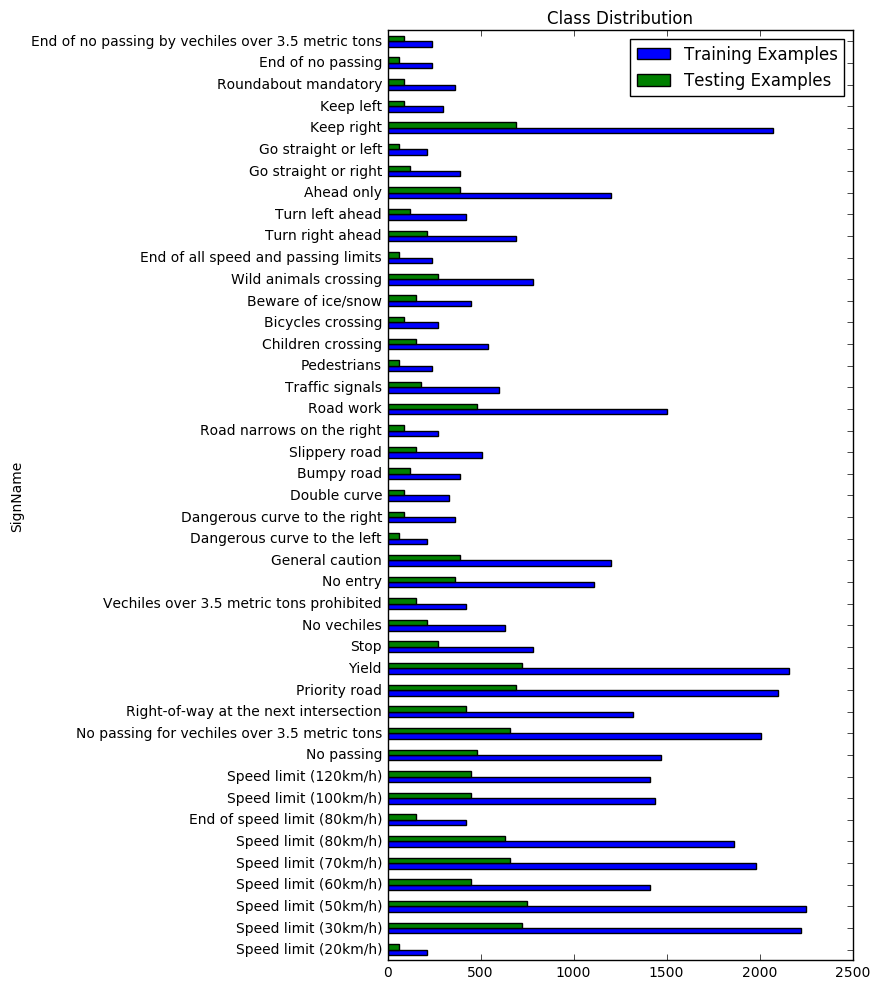

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# DataFrame with counts of each sign class
signnames = pd.read_csv('signnames.csv')
train_counts = Counter(y_train)
test_counts = Counter(y_test)

counts = pd.DataFrame.from_dict(train_counts, orient='index').reset_index()
counts.columns = ['ClassId', 'Training Examples']

test_counts = pd.DataFrame.from_dict(test_counts, orient='index').reset_index()
test_counts.columns = ['ClassId', 'Testing Examples']

counts = pd.merge(counts, signnames, on='ClassId')
counts = pd.merge(counts, test_counts, on='ClassId')


# Bar chart
counts.plot.barh(x='SignName', y=['Training Examples', 'Testing Examples'], title='Class Distribution', figsize=(6,12));
plt.show()

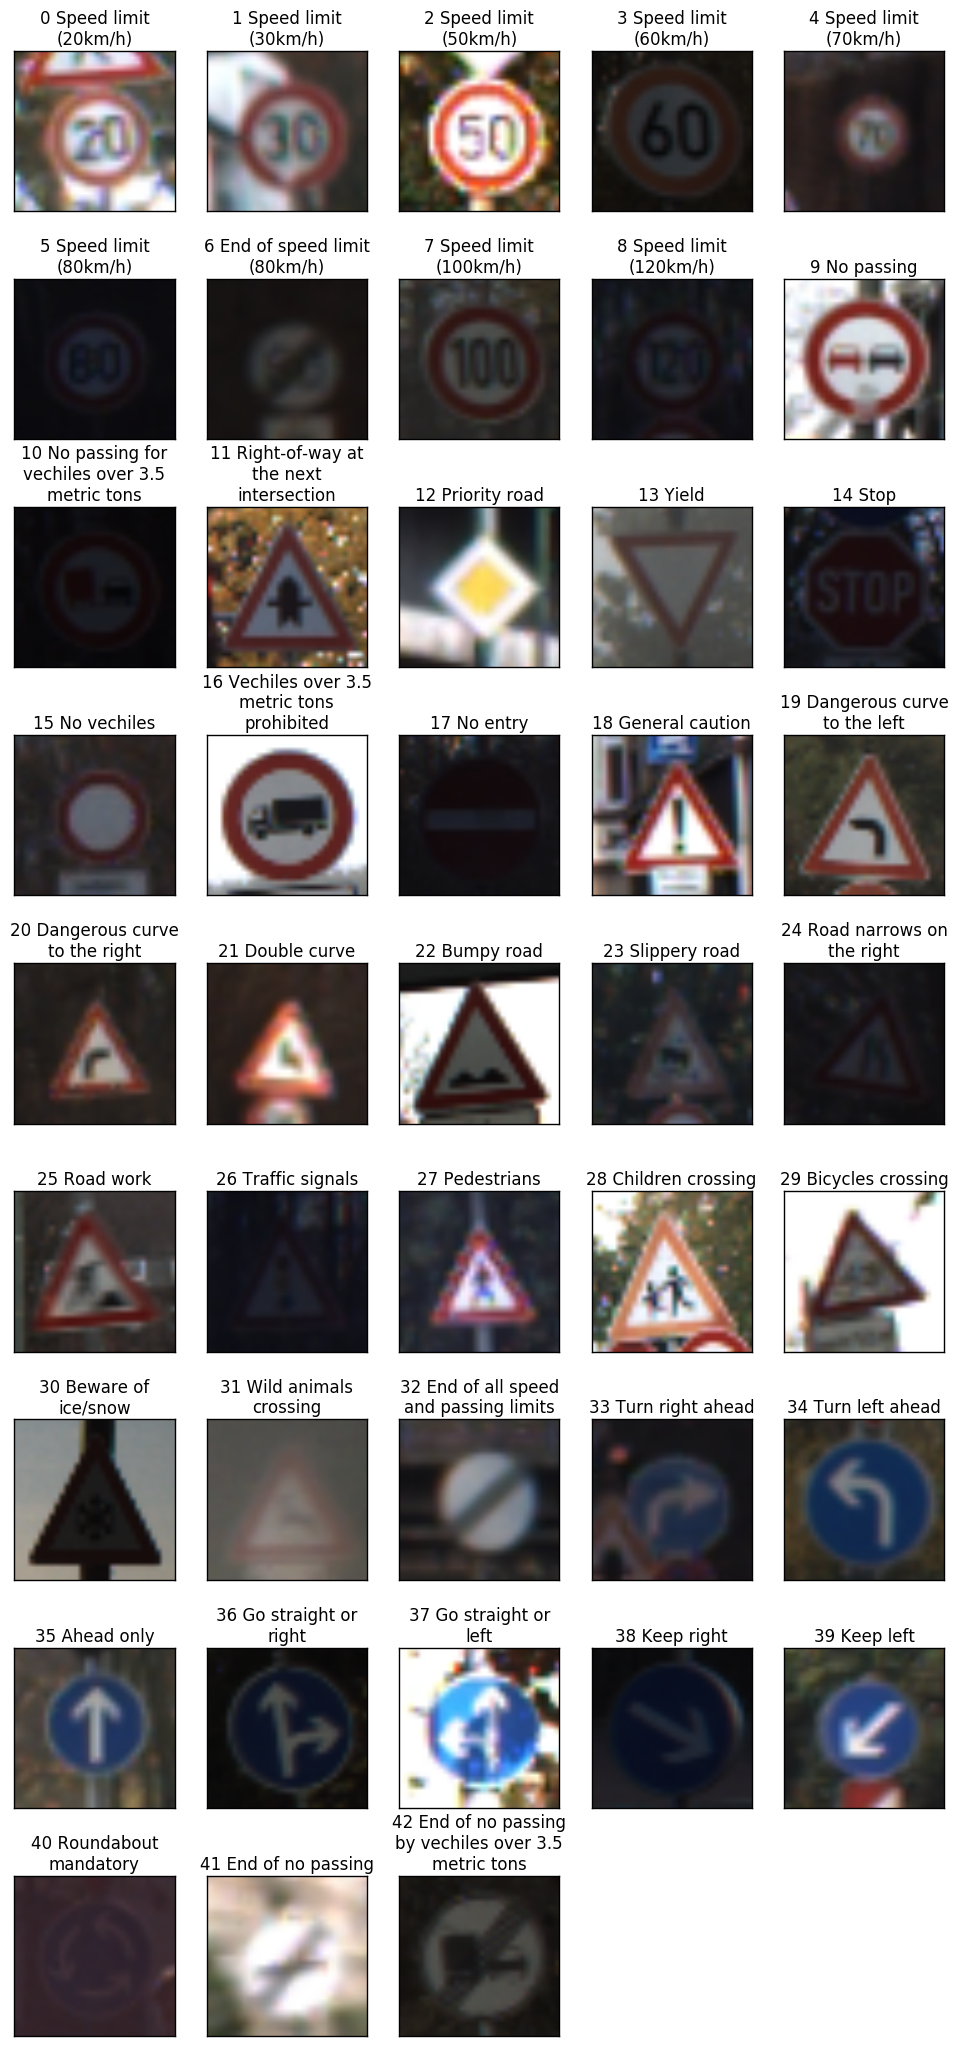

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from textwrap import wrap

# For each class, display a random image
def plot_images(images, y_true = [], y_pred = []):
    plt.subplots(figsize=(12, 26))
    for i, image in enumerate(images):

        text = ''
        if len(y_true):
            text = text + str(i) + ' ' + signnames[signnames['ClassId'] == y_true[i]].iloc[0]['SignName']

        if len(y_pred):
            text = text + ' predicted: ' + str(i) + ' ' + signnames[signnames['ClassId'] == y_pred[i]].iloc[0]['SignName']
        
        subplot = plt.subplot(9, 5, i+1)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.title.set_text("\n".join(wrap(text, 20)))
        plt.imshow(image, cmap=plt.get_cmap('gray'))

    plt.show()

images = []
labels = []
for i in set(y_train):
    class_indexes = np.where(y_train == i)[0]
    random_choice = np.random.choice(class_indexes)
    images.append(X_train[random_choice])
    labels.append(i)

plot_images(images, labels)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
# Load images to preprocess from scratch each time
# Note: Original train data used as validation data.
X_validate, y_validate = load_images(training_file)
X_test, y_test = load_images(testing_file)
import cv2
from sklearn.utils import shuffle

# Preprocess
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X)) - 0.5

X_validate = normalize(np.array([grayscale(image) for image in X_validate]))
X_validate, y_validate = shuffle(X_validate, y_validate, random_state=0)
X_test = normalize(np.array([grayscale(image) for image in X_test]))

print("Done")

Done


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** My first step in preprocessing consisted of reducing to grayscale images.  After looking at the signs, color does not seem to be a needed factor for sign classification, since each sign is distinct using the shape content alone.  Considering this, I opted to convert to grayscale, reducing the dimensionality of the input data.

Next, the images are normalized to values ranging from -0.5 to 0.5.  This helps keep values small, improving numerical stability.  In addition since our mean is relatively close to 0, the gradient descent optimization will have less searching to do when minimizing loss.

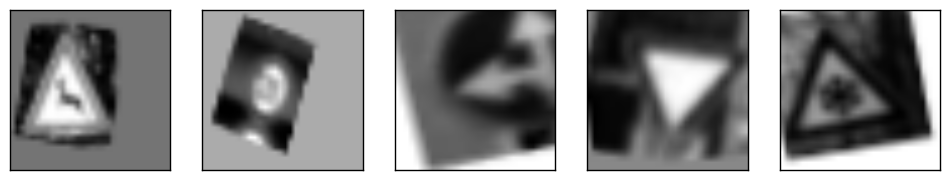

Done


In [17]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import cv2

def create_images(X_source, y_source, numImages):
    num = 0
    indexes = {}
    images = []
    labels = []
    while num < numImages:
        # get random label
        label = np.random.choice(range(n_classes))
        # get index of random image + label
        if indexes.get(label) is None:
            indexes[label] = [i for i, y in enumerate(y_source) if y == label]
        index = np.random.choice(indexes[label])
        # get transformed image
        image = transform_image(X_source[index], 20, 10, 5)
        
        images.append(image)
        labels.append(label)
        num += 1

    return np.array(images), np.array(labels)

# Source: https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image
def transform_image(img, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(-ang_range, ang_range)
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = np.random.uniform(-trans_range, trans_range)
    tr_y = np.random.uniform(-trans_range, trans_range)
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    return img

# Note: This is just the function for generating images
# Training images are generated below when training the network
num_generated_images = 5
X_example, y_example = create_images(X_validate, y_validate, num_generated_images)    
plot_images(X_example)

print("Done")

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

*Training Data* - Instead of using the original training set as training data, I opted to generate random jittered images.
- Training using the generated training allows training on many more examples.
- Since images are generated with a more balanced distribution, we avoid bias due to unbalanced classes.

*Validation Data* - Because additional data is generated for training data, this allows the original training to be used as validation data instead.

*Test Data* - Test data remains as given.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Input data.
import tensorflow as tf
tf.reset_default_graph()

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def conv2d(input, num_input_channels, filter_size, num_filters):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases

    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights

def fully_connected(input, num_inputs, num_outputs, use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

image_size = 32
num_channels = 1

# Placeholders
X = tf.placeholder(tf.float32, shape=[None, image_size, image_size], name='X')
y_true = tf.placeholder(tf.int64, name='y_true')
keep_prob = tf.placeholder(tf.float32)
weight_decay = tf.placeholder(tf.float32)

# Reshape Input, Labels
tf_X = tf.reshape(X, [-1, image_size, image_size, num_channels])
y_true_one_hot = tf.one_hot(y_true, n_classes)

# Network
with tf.name_scope('convolutional-1'):
    conv1_layer, conv1_weights = conv2d(tf_X, num_channels, 5, 16)
with tf.name_scope('convolutional-2'):
    conv2_layer, conv2_weights = conv2d(conv1_layer, 16, 5, 32)
with tf.name_scope('flatten'):
    flat_layer, num_features = flatten_layer(conv2_layer)
with tf.name_scope('fully-connected-1'):
    fc1_layer, fc1_weights = fully_connected(input=flat_layer, num_inputs=num_features, num_outputs=128, use_relu=True)
with tf.name_scope('dropout'):
    dropout_layer = tf.nn.dropout(fc1_layer, keep_prob)
with tf.name_scope('fully-connected-2'):
    fc2_layer, fc2_weights = fully_connected(input=dropout_layer, num_inputs=128, num_outputs=n_classes, use_relu=False)

# y_pred
y_pred_softmax = tf.nn.softmax(fc2_layer)
y_pred_softmax_top = tf.nn.top_k(y_pred_softmax, k=5)
y_pred = tf.argmax(y_pred_softmax, dimension=1)

# loss
l2_loss = tf.mul(tf.add_n([
    tf.nn.l2_loss(conv1_weights),
    tf.nn.l2_loss(conv2_weights),
    tf.nn.l2_loss(fc1_weights),
    tf.nn.l2_loss(fc2_weights)
]), weight_decay, name='l2_loss')
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2_layer, labels=y_true_one_hot), name='cross_entropy')
loss = tf.add(cross_entropy, l2_loss, name='loss')
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2_layer, labels=y_true_one_hot), name='loss')
tf.scalar_summary('loss', loss)

# optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss)

# accuracy
correct_prediction = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.scalar_summary('accuracy', accuracy)

# summaries
all_summaries = tf.merge_all_summaries()

print("Done")

Done


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** My architecture is a traditional feed-forward layered architecture in which the output of one layer is fed to the layer above.  At a high level the pipeline consists of two convolutional layers, followed by two fully connected layers.

Each convolutional layer has a 1x1 stride, using on a 2x2 max pooling operation to reduce spatial resolution, followed by a RELU activation to introduce non-linearity.  The output from the second convolutional layer is flattened and fed into a classifier composed of two fully connected layers.

The first fully connected layer is fed through another RELU activation followed by a dropout operation.  The dropout operation randomly wipes out data being fed into the final fully connected layer, forcing it to learn redundancy for any given feature.  A softmax is performed on the output from the final layer, which is then used for minimizing loss and making predictions.

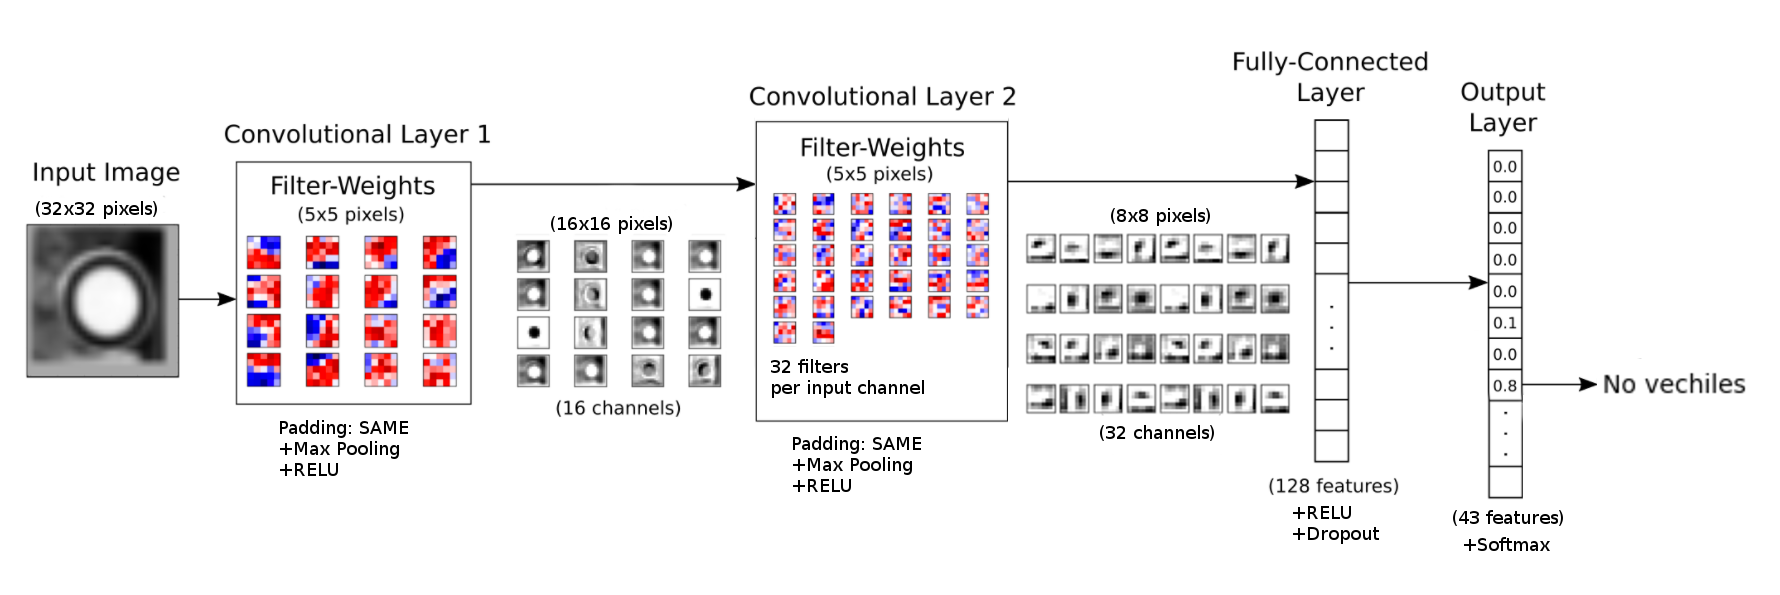

In [80]:
# Original Image: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
from IPython.display import Image
Image('images/architecture.png')

In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.
session = tf.Session()
session.run(tf.initialize_all_variables())
print("Done")

Done


In [10]:
# Setup Network Saver
import os
saver = tf.train.Saver()
save_dir = 'checkpoints/'
save_path = save_dir + 'best_validation'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Summary Writer
train_writer = tf.train.SummaryWriter('log/train', session.graph)
validate_writer = tf.train.SummaryWriter('log/validate')
    
print("Done")

Done


In [11]:
# Restore Network
saver.restore(sess=session, save_path=save_path)
print("Done")

Done


In [938]:
# Train Network
batch_size = 128
num_generated_images = 128000
num_steps = int(num_generated_images / batch_size)
epochs = 5

for epoch in (range(epochs)):
    print("Epoch: ", epoch + 1)

    print("Creating Images")
    X_train, y_train = create_images(X_validate, y_validate, num_generated_images)

    print('Training')
    start = epoch * num_steps
    for step in range(start, start + num_steps):

        # Run optimization on train data, but every few steps check validation accuracy
        if (step % 30 == 0):
            batch_data, batch_labels = X_validate, y_validate
            batch_keep_prob = 1.0
            batch_weight_decay = 0
            batch_operations = {'summary': all_summaries, 'accuracy': accuracy, 'loss': loss}
            summary_writer = validate_writer
        else:
            batch_data, batch_labels = X_test, y_test
            batch_keep_prob = 0.6
            batch_weight_decay = 1e-4
            batch_operations = {'summary': all_summaries, 'accuracy': accuracy, 'loss': loss, 'optimizer': optimizer}
            summary_writer = train_writer

        # get batch slice
        offset = (step * batch_size) % (batch_data.shape[0] - batch_size)
        batch_data = batch_data[offset:(offset + batch_size), :, :]
        batch_labels = batch_labels[offset:(offset + batch_size)]

        # run operations
        feed_dict = {X: batch_data, y_true: batch_labels, keep_prob: batch_keep_prob, weight_decay: batch_weight_decay}
        results = session.run(batch_operations, feed_dict=feed_dict)

        # writer summary
        summary_writer.add_summary(results['summary'], step)

print("Done")

Epoch:  1
Creating Images
Training
Epoch:  2
Creating Images
Training
Epoch:  3
Creating Images
Training
Epoch:  4
Creating Images
Training
Epoch:  5
Creating Images
Training
Done


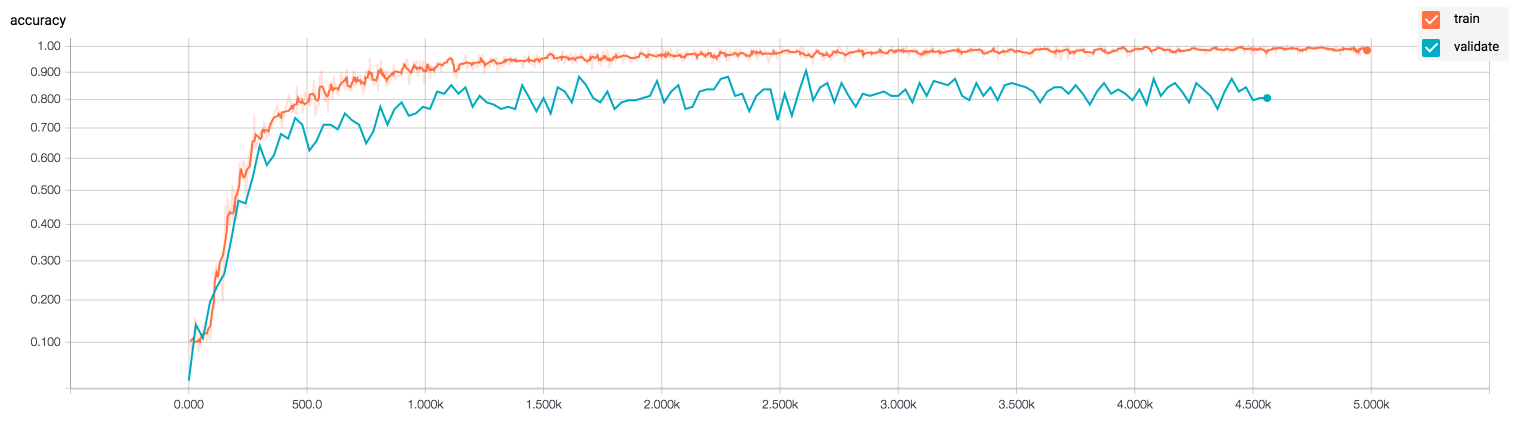

In [3]:
from IPython.display import Image
Image('images/TensorBoard.png')

In [948]:
# Save Checkout
saver.save(sess=session, save_path=save_path)
print("Done")

Done


Validation accuracy 84.85%


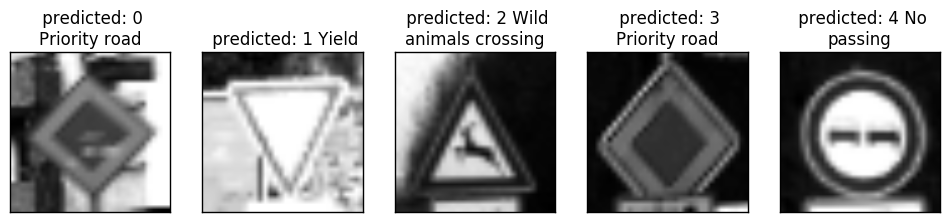

In [15]:
feed_dict={X: X_validate, y_true: y_validate, keep_prob: 1.0}
validate_y_pred, validate_y_true, acc = session.run([y_pred, y_true, accuracy], feed_dict=feed_dict)
print("Validation accuracy {0:.2%}".format(acc))

plot_images(X_validate[:5], y_pred=validate_y_pred[:5])

Test accuracy 99.97%


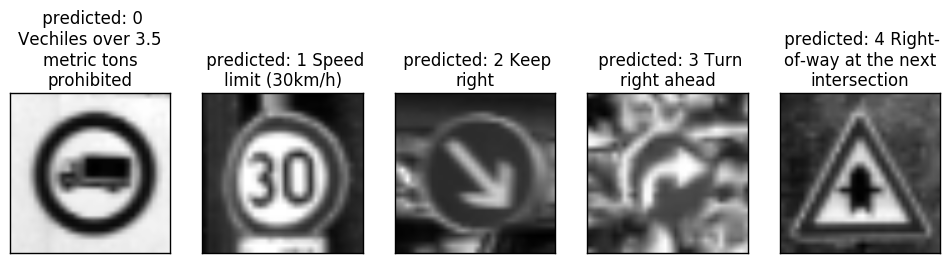

In [16]:
feed_dict={X: X_test, y_true: y_test, keep_prob: 1.0}
test_y_pred, test_y_true, acc = session.run([y_pred, y_true, accuracy], feed_dict=feed_dict)
print("Test accuracy {0:.2%}".format(acc))

plot_images(X_test[:5], y_pred=test_y_pred[:5])

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

*Optimizer* - I chose Adam Optimizer, which automatically handles decayed learning rate, and momentum.  My reasoning is that I could focus on experimenting and learning network architecture instead of tweaking hyper parameters.

*Batch Size* - I chose 128 for my batch size.  Much larger and I ran into significant slowdown in how long it took to train my network.

*Steps* - For number of steps, I calculated based on the number of generated images and the batch size.  I generated 128,000 images per epoch, so images / batch size = 1000 steps

*Epoch* - I chose 5 epochs, generating 128,000 images with each epoch.

*L2 Weight Decay* - In experimenting, I found that without a weight decay, the l2 loss severely overpowered the cross entropy loss.  I settled on a value of 1e-4 for weight decay.

*Dropout Keep Probability* - I found that a keep probability around 0.6 allowed my network to both learn from data and also not over fit.

*Validation* - For both train and validation I chose to leverage TensorBoard to monitor the learning curves.  At every 10 steps, I run accuracy on a small validation batch instead of running the training optimizer.  If I found that my model did not generalize well against my validation set, I went back to tweaking my network layers and adjusting the regularization.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

Because we are working with images, I chose to leverage convolutional networks, since they are able to learn features invariant to translation, rotation and shifting.  A deep network consisting of only fully connected layers was also considered, but this approach would not be able to benefit from the spatial representation of the image, treating all pixels as independent features.

Next, in order to learn the basics of convolutional networks, I chose to model my architecture after Lenet-5, a known architecture that performs well with image classification.

In constructing my layers, I tried different number of output channels, and the number of convolutional layers. I chose to go with two convolutional layers since our input images are relatively simplistic consisting of simple shapes. The first convolutional layer can learn lines or edges, while the second convolutional layer can piece together shapes. For output channels, I tried to increase depth about the same rate I was decreasing the spatial dimensionality.



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

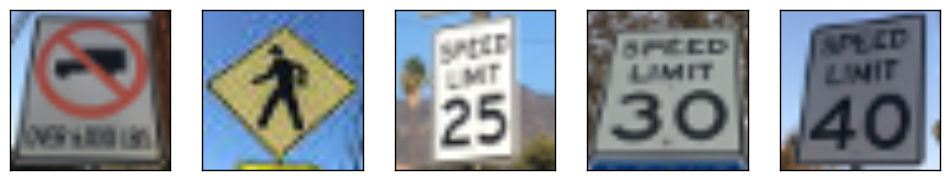

In [855]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
new_images, labels = load_images('new.p')
plot_images(new_images)
new_images = normalize(np.array([grayscale(image) for image in new_images]))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** Classification might be difficult on my five images for a variety of reaons.  While the signs share similarities with the training data, there are notable differences.  One big difference is the shape of the signs are different, for example the pedestrian sign has a triangle shape in the training data, while the one I captured has a diamond shape.

The symbols within the signs also differ. For example, the vehicles prohibited over 3.5 metric tons and my captured image for vehicles prohibited over 6000 lbs, do have a similar picture of a truck inside a circle, but in my captured image there is also a slash through the circle.

Another difference is that there are different speed limits.  Even though there are no equivalent classes for 25 MPH and 40 MPH signs in the training data, I decided to include these to see if the classifier chose a speed limit containing similar numbers.

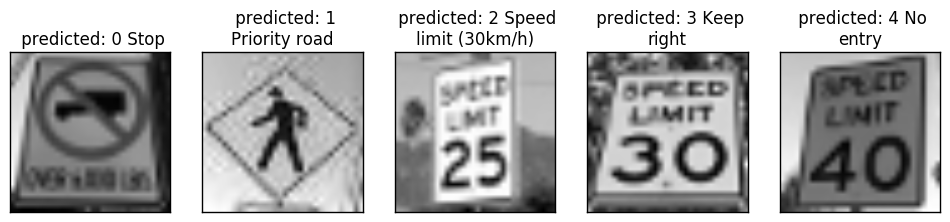

In [971]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
feed_dict={X: new_images, keep_prob: 1.0}
softmax, pred, pred_softmax_top = session.run([y_pred_softmax, y_pred, y_pred_softmax_top], feed_dict=feed_dict)
plot_images(new_images, y_pred=pred)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** My models performs poorly on my captured images compared to the test dataset.  Of my five images, my model has 0% accuracy while having 99.97% accuracy on the test dataset.  This is understandable since my captured images are from a different country, and some of them don't even have a corresponding label in the test dataset.

Classification on a live camera stream would require adjustments to the pipeline to be effective.

One issue is the live video stream will not have the sign nicely cropped and centered as in the training data. I would expect the classifier to perform poorly if given the entire image.  A simplified classifier might first discover the bounding box of sign candidates by scanning over the image in a small window.

Another concern might be how to speed up the classifier so that there is no lag between the live feed and the classification.  One way we could do this is by splitting into several simplified classifiers using cost efficient methods based on shape or color thresholding.  These simplified classifiers would have less parameters and be able to execute more quickly than a network responsible for classifying every sign.

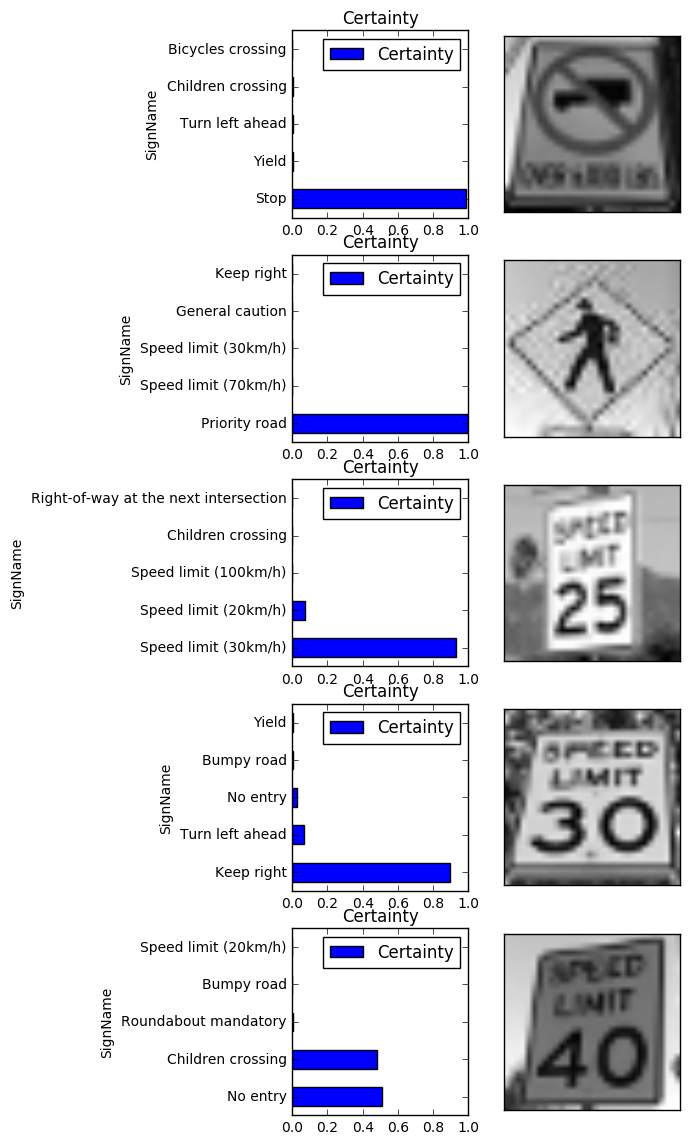

In [990]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(5, 14))
for idx, indices in enumerate(pred_softmax_top.indices):

    values = pred_softmax_top.values[idx]
    certainty = signnames.loc[indices, :]
    certainty['Certainty'] = pd.Series(values, index=certainty.index)

    certainty.plot(ax=axes[idx, 0], x='SignName', y='Certainty', title='Certainty', kind='barh', xlim=(0,1.0))
    
    subplot = plt.subplot(5, 2, idx*2 + 2)
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
    plt.imshow(new_images[idx], cmap=plt.get_cmap('gray'))

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

*Vehicles over 6000 lbs prohibited* - The model is certain that this is a stop sign with a softmax probability of around 1.0.  I was hoping the symbol shape was similar enough to the Vehicles of 3.5 metric tons prohibited sign, but it seems that the are too many differences.

*Pedestrians* - The model is certain that this sign is a Priority road sign with a softmax probability around 1.0.  This one is surprising for me since the pedestrian symbols are so similar.

*25 mph* - This sign is not in the original dataset, but the highest two values are 30km/h and 20km/h, with a high certainty (> 0.9) for 30km/h.

*30 mph* - The model is certain that this sign is a keep right sign with a softmax probabily of 0.9.  This one is a little dissapointing since 30km/h is actually a sign in the original training data.

*40 mph* - This sign is not in the original dataset, but I was curious to see if the model chose one of the speed limits as a classification.  Te model is less certain with this one with about 0.51 softmax probability for No Entry and 0.48 for Children Crossing.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.